<a href="https://colab.research.google.com/github/yqx674834119/ADVENT/blob/master/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-92g8w7ue
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-92g8w7ue
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=2d8000e3260354b4accf89668f799123163bf701e9aa2c7ab2062b4525dfaa02
  Stored in directory: /tmp/pip-ephem-wheel-cache-jdq02lva/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


In [ ]:
sam_checkpoint = "/content/drive/MyDrive/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"
# sam_checkpoint = '/content/drive/MyDrive/SAM/sam_vit_b_01ec64.pth'
# model_type = "vit_b"


In [ ]:
[255,43,24],[242, 253, 44],[7, 253, 253],[92, 17, 252]

rgb = np.array([[245, 34, 45],[250, 173, 20],[82, 196, 26],[47, 84, 235]])/255.

In [ ]:
def show_anns(anns,orignal_img):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    flag = np.ones(( sorted_anns[0]['segmentation'].shape[0],  sorted_anns[0]['segmentation'].shape[1]))
    flag [:,:]=False
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    masks = []
    bit_img = np.array(orignal_img[:,:,0], dtype=bool)

    for ann in sorted_anns:
        m = ann['segmentation']

        m = np.pad(m, ((5, 5), (5, 5)), 'constant', constant_values=0)
        m = np.asarray(m*255, dtype=np.double)
        gx, gy = np.gradient(m)
        temp_edge = gy * gy + gx * gx
        temp_edge[temp_edge != 0.0] = 255.0
        temp_edge = np.asarray(temp_edge/255, dtype=np.uint8)

        # temp_edge = m*0.8


        img = np.ones((m.shape[0], m.shape[1], 3))
        # color_mask = [255/255.,43/255.,24/255.]
        # color_mask = [242/255.,253/255.,44/255.]
        color_mask = rgb[1]
        # color_mask = [92/255., 17/255., 252/255.]

        # color_mask = np.random.random((1, 3)).tolist()[0]

        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, temp_edge)))
        masks.append(ann)
    return masks

In [ ]:
def calculate_anns(anns,orignal_img):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    flag = np.ones(( sorted_anns[0]['segmentation'].shape[0],  sorted_anns[0]['segmentation'].shape[1]))
    flag [:,:]=False
    polygons = []
    color = []
    masks = []
    bit_img = np.array(orignal_img[:,:,0], dtype=bool)

    for ann in sorted_anns:
        m = ann['segmentation']
        # 求IOU
        if(not bit_img[m==True].all()):
            continue
        # 如果和bit_img 一样
        if(m.sum()/bit_img.sum()>0.9):
            continue
        # 求叠加状态
        if(flag[m == True].sum()/m.sum()> 0.5):
            continue
        flag [m == True] =True
        masks.append(ann)
    return masks

def HeadTail(list_in,reverse =True ,thresh = False):
    list_in = sorted(list_in, key=(lambda x: x['area']), reverse=True)
    list_in = [i['area'] for i in list_in]
    head_index=[]
    temp_list = list_in
    hierarchy_index = 1
    while(1):
        head_len = 0
        mean = np.mean(temp_list)
        if(reverse):
            while(temp_list[head_len]>mean):
                head_len=head_len+1
        else:
            while(temp_list[head_len]<mean):
                head_len=head_len+1
        head=temp_list[:head_len]

        if(thresh and head_len/len(temp_list)<0.4):
            break
        head_index.append(head_len)
        temp_list=head
        hierarchy_index = hierarchy_index+1
        if(head_len ==0 ):
            hierarchy_index = hierarchy_index-1
            break
        if(head_len ==1 ):
            break

    return np.array(head_index),hierarchy_index

In [ ]:
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


In [ ]:
img_path = '/content/drive/MyDrive/SAM/test5.png'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
grid_num = 16
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=grid_num,
    # pred_iou_thresh=0, # IOU
    # stability_score_thresh=0,
    # crop_n_layers=1,
    # crop_n_points_downscale_factor = 2,
    # crop_nms_thresh = 1,
    min_mask_region_area=400
)

In [ ]:
# print(len(mask_generator.point_grids)) [1,256,2]

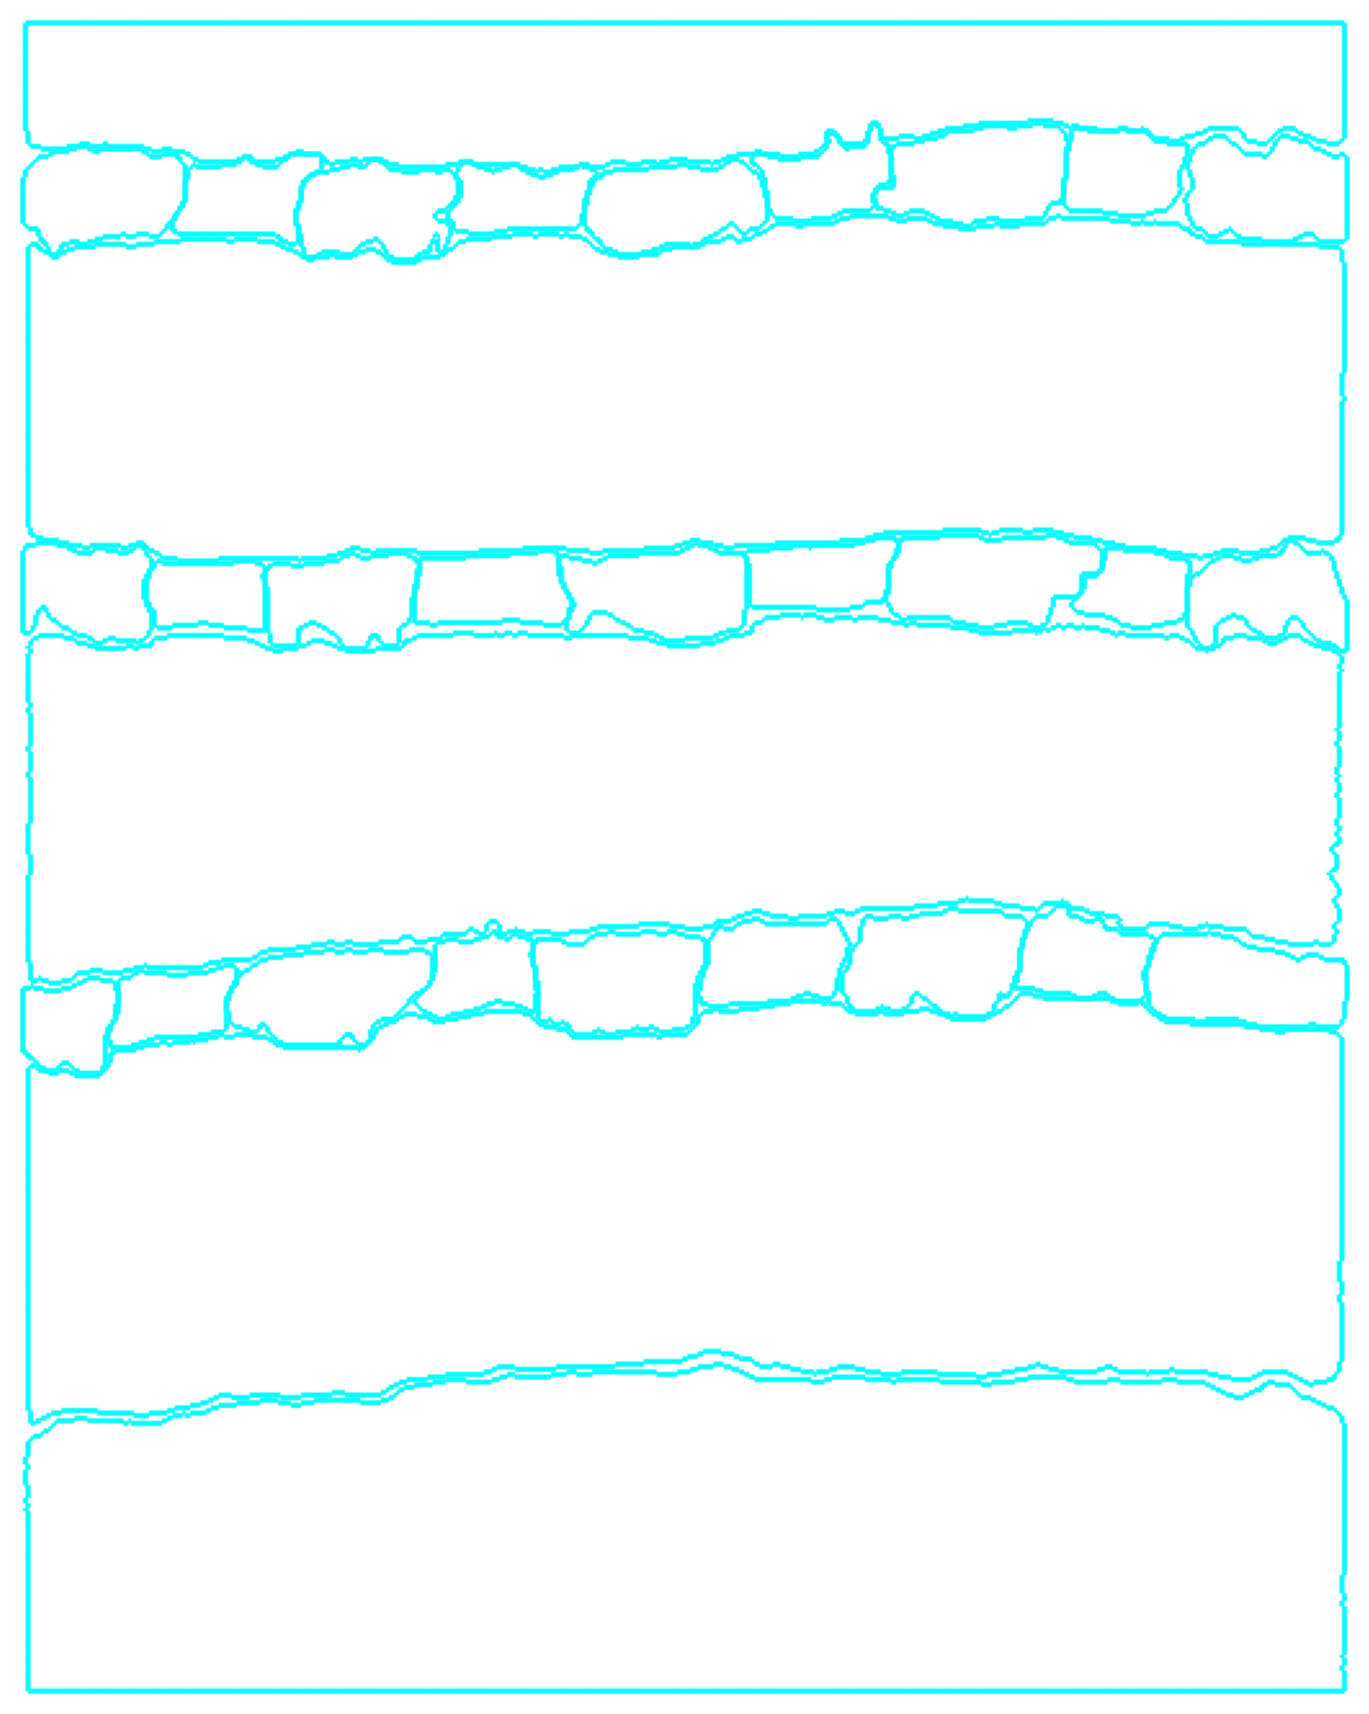

1	1	28	3.00	84


KeyboardInterrupt: ignored

In [ ]:

image_list = [image]
masks_list = []
count_id = 1
while(1):
    # print(len(image_list))
    if(len(image_list)==0):
        break
    maskes_list_temp = []
    Image_list_temp = []

    sub_structure = 0
    D = 0
    LR = 0

    for parent_id,Img in enumerate(image_list):
        maskses = mask_generator.generate(Img)
        maskses = calculate_anns(maskses,Img)

        S = len(maskses)
        # print(len(maskses))
        sub_structure =sub_structure+S

        if(S):
            # head-tail breaks
            area_head_tail,hierarchy_index = HeadTail(maskses)
            # print(area_head_tail)
            D =D+1
            LR = LR+S*hierarchy_index

        # print('\t',len(maskses))
        maskes_list_temp.extend(maskses)
        sorted_anns = sorted(maskses, key=(lambda x: x['area']), reverse=True)
        for img_id,ann in enumerate(sorted_anns):
            m = ann['segmentation']
            img = Img.copy()
            for i in range(3):
                img[:,:,i] = img[:,:,i]*m
            Image_list_temp.append(img)
            savepath = img_path.split('.png')[0]+'_{}_{}_{}.png'.format(count_id,parent_id,img_id)
            # cv2.imwrite(savepath,cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.figure(figsize=(22,22))
    back_image = np.zeros_like(image,dtype = np.uint8)+255
    back_image = np.pad(back_image, ((5, 5), (5, 5),(0,0)), 'constant', constant_values=255)
    plt.imshow(back_image)
    maskses = show_anns(maskes_list_temp,image)
    plt.axis('off')
    plt.show()
    count_id = count_id+1
    image_list = Image_list_temp
    masks_list.extend(maskes_list_temp)
    print('{}\t{}\t{}\t{:.2f}\t{}'.format(count_id-1,D,sub_structure,LR/sub_structure,LR))
    # mask_generator.min_mask_region_area =1000
    # mask_generator.points_per_side = grid_num*2


In [ ]:

image_list = [image]
masks_list = []
count_id = 1
while(1):
    # print(len(image_list))
    if(len(image_list)==0):
        break
    maskes_list_temp = []
    Image_list_temp = []

    sub_structure = 0
    D = 0
    LR = 0
    for parent_id,Img in enumerate(image_list):
        maskses = mask_generator.generate(Img)

        plt.figure(figsize=(20,20))
        plt.imshow(Img)
        # maskses = calculate_anns(maskses,Img)
        maskses = show_anns(maskses,Img)
        S = len(maskses)
        # print(len(maskses))
        sub_structure =sub_structure+S

        if(S):
            # head-tail breaks
            area_head_tail,hierarchy_index = HeadTail(maskses)
            # print(area_head_tail)
            D =D+1
            LR = LR+S*hierarchy_index
        plt.axis('off')
        plt.show()
        # print('\t',len(maskses))
        maskes_list_temp.extend(maskses)
        sorted_anns = sorted(maskses, key=(lambda x: x['area']), reverse=True)
        for img_id,ann in enumerate(sorted_anns):
            m = ann['segmentation']
            img = Img.copy()
            for i in range(3):
                img[:,:,i] = img[:,:,i]*m
            Image_list_temp.append(img)
            savepath = img_path.split('.png')[0]+'_{}_{}_{}.png'.format(count_id,parent_id,img_id)
            # cv2.imwrite(savepath,cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    count_id = count_id+1
    image_list = Image_list_temp
    masks_list.extend(maskes_list_temp)
    print('{}\t{}\t{}\t{:.2f}\t{}'.format(count_id-1,D,sub_structure,LR/sub_structure,LR))


In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
)
maskses = mask_generator.generate(image)
for ann in maskses:
    m = ann['segmentation']
    img = image.copy()
    for i in range(3):
        img[:,:,i] = img[:,:,i]*m
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
ax = plt.gca()
for ann in maskses:
    x,y= ann['point_coords'][0]
    m = ann['segmentation']
    img = np.ones((m.shape[0], m.shape[1], 3))
    color_mask = np.random.random((1, 3)).tolist()[0]
    for i in range(3):
        img[:,:,i] = color_mask[i]
    ax.imshow(np.dstack((img, m*0.8)))
    plt.scatter(x,y)
# plt.axis('off')
plt.show()

In [ ]:
from segment_anything import sam_model_registry, SamPredictor
# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
input_point = np.array([[250, 70]])
input_label = np.array([1])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

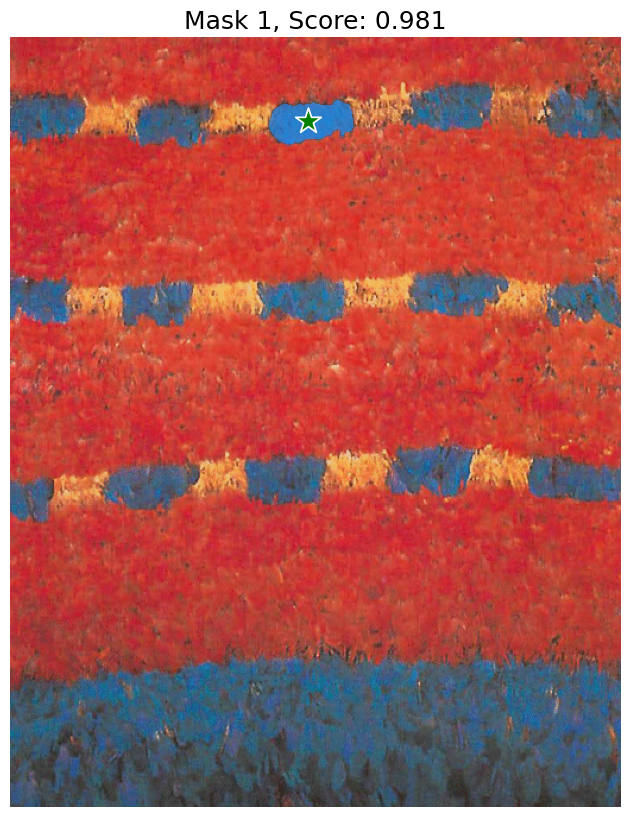

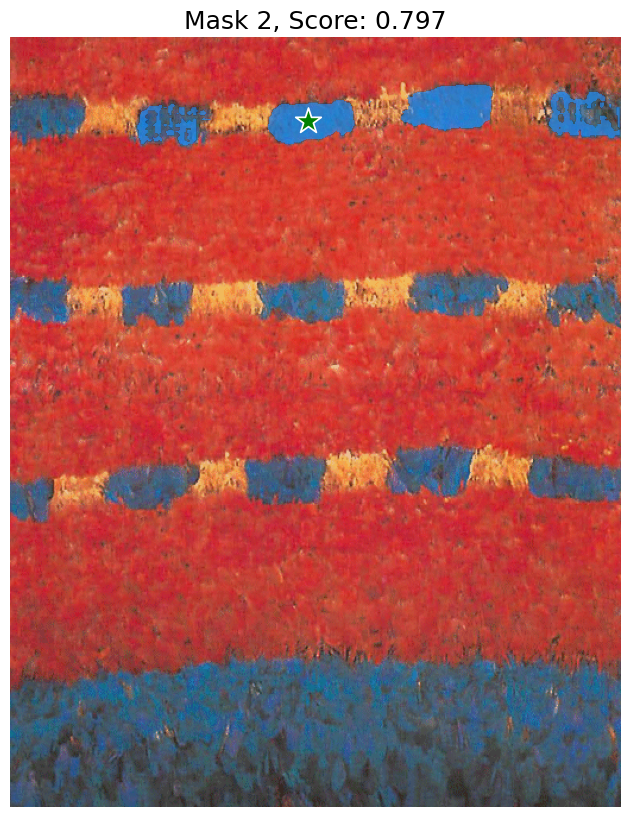

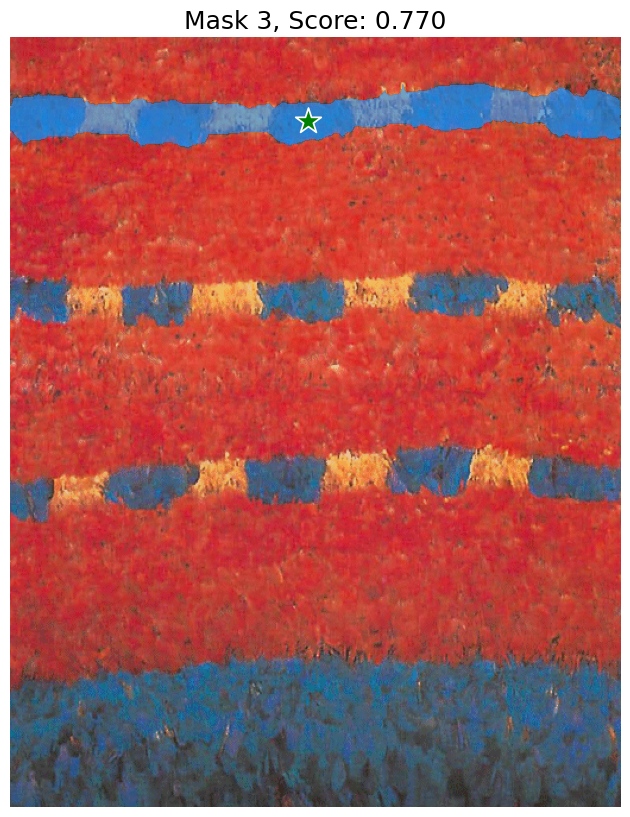

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
